In [1]:
import numpy as np
from time import time
#import numpy to optimize calculations with arrays
#import time to measure calculation time

# Code Notation:
# Symbol in Paper, Spelling in Code
# θ, theta
# φ, phi
# ψ, psi
# α, alpha
# β, beta
# γ, gamma
# ξ, xi
# E, big_e
# G, big_g
# 2π-φ, psi2

In [4]:
#For Cylinder to Plane, Here are 2 Methods:
#  Traditional Iteration
#  Array Calculation
#Random variables are generated in functions rand_gen_*
#  For example, z0 is generated in rand_gen_z0
#Other Variables are generated in functions f_*
#  For example, x0 is found in f_x0

#psi2 is 2pi - psi
def f_psi2(psi):
    return 2 * np.pi - psi
def f_big_e(phi,psi,fast=True):
    if fast:
        return f_big_e_fast(phi,psi)
    return phi if psi <= np.pi else phi + np.pi
#When running array calculation, use f_big_e_fast instead of f_big_e
def f_big_e_fast(phi,psi):
    big_e = phi.copy()
    I = psi > np.pi
    big_e[I] = np.pi + big_e[I]
    return big_e
def f_x0(xc,rc,psi):
    return xc - rc * np.sin(psi)
def f_y0(yc,rc,psi):
    return yc - rc * np.cos(psi)

#NOTE! if emission never touches x0, function will likely return very large number, or possibly nan
#NOTE! r may be negative, which should be filtered as no touch
def f_r(x0,theta,phi,psi,fast=False):
    psi_2 = f_psi2(psi)
    big_e = f_big_e(phi,psi,fast=fast)
    return (-1*x0)/(
        (np.cos(theta) * np.sin(psi_2)) + 
        (np.sin(theta) * np.cos(big_e)*np.cos(psi_2))
        )
def f_y(r,y0,theta,phi,psi,fast=False):
    psi_2 = f_psi2(psi)
    big_e = f_big_e(phi,psi,fast=fast)
    return y0 - r *np.cos(theta)* np.cos(psi_2) + r * np.sin(theta) * np.cos(big_e) * np.sin(psi_2)
def f_z(r,z0,theta,phi):
    return z0 - r* np.sin(theta) * np.sin(phi)
def f_calc_ryz(xc,yc,z0, theta,phi,psi,rc,fast=False):
    #print(xc,yc,z0.shape,theta.shape,phi.shape,psi.shape,rc)
    x0= f_x0(xc,rc,psi)
    y0 = f_y0(yc,rc,psi)
    r = f_r(x0,theta,phi,psi,fast=fast)
    y = f_y(r,y0,theta,phi,psi,fast=fast)
    z = f_z(r,z0,theta,phi)
    return r,y,z
def rand_gen_theta(shape):
    return np.arcsin(np.sqrt(np.random.random(shape)))
def rand_gen_phi(shape):
    return np.random.random(shape) * 2 * np.pi
def rand_gen_psi(shape):
    return np.random.random(shape) * 2 * np.pi
def rand_gen_z0(shape,zmax,zmin):
    return np.random.random(shape) * (zmax-zmin) +zmin

#Traditional Iteration:
#  Over many iterations:
#    Generate individual random variables
#    Calculate
#    If valid add to count
#  Divide count by total iteratiokns
def main_A_12(num_iterations):
    count=0
    shape = ()
    #initial parameters
    target_ymin = 0
    target_ymax = 8
    target_zmin = -8
    target_zmax = -2
    
    for _ in range(num_iterations):
        r,y,z = f_calc_ryz(
            xc = 5.0,
            yc = 4.0,
            z0 = rand_gen_z0(shape,zmax=target_zmax,zmin=target_zmin),
            theta = rand_gen_theta(shape),
            phi = rand_gen_phi(shape),
            psi = rand_gen_psi(shape),
            rc = 2.0,
            fast=False
            )
        #SKIP if r < 0. It means ray goes opposite direction of plane
        if r < 0:
            continue
        if y >= target_ymin:
            if y <= target_ymax:
                if z >= target_zmin:
                    if z<=target_zmax:
                        count+=1
    return count / num_iterations

# Note: Running calculations in an array, we an run the simulation an order of magnitude faster
# Array Calculation:
#   Generate random variables in array
#   Calculate in array
#   Find valid points using booleans in array
#   Sum final boolean array and divide by length of array
def main_A_12_fast(num_iterations):
    shape = (num_iterations,)
    # Initial parameters
    target_ymin = 0
    target_ymax = 8
    target_zmin = -8
    target_zmax = -2

    r,y,z = f_calc_ryz(
            xc = 5.0,
            yc = 4.0,
            z0 = rand_gen_z0(shape,zmax = target_zmax,zmin=target_zmin),
            theta = rand_gen_theta(shape),
            phi = rand_gen_phi(shape),
            psi = rand_gen_psi(shape),
            rc = 2.0,
            fast=True
            )
    y_pass = np.logical_and(y>=target_ymin, y<=target_ymax)
    z_pass = np.logical_and(z>=target_zmin,z<=target_zmax)
    yz_pass = np.logical_and(y_pass,z_pass)
    r_pass = np.logical_and(yz_pass,r>0)
    
    return np.sum(r_pass) / num_iterations
def print_result_and_time(iterations,theory,method):
    iterations = int(iterations)
    t = time()
    if method=='12':
        res = main_A_12(iterations)
        meth_str ='C=>P, Iteration'
    elif method=='12_fast':
        res = main_A_12_fast(iterations)
        meth_str = 'C=>P, Array'
    elif method=='21_fast':
        res=main_A_21_fast(iterations)
        meth_str = 'P=>C, Array'
    elif method=='b_12_fast':
        res=main_B_12_fast(iterations)
        meth_str = 'S=>C, Array'
    elif method=='b_21_fast':
        res=main_B_21_fast(iterations)
        meth_str = 'C=>S, Array'
    print('Num_Iter:{:1.0e} Result:{:.4f} Error:{:1.1f}% TimeElapsed:{:1.2f} Method:{}'
          .format(iterations,res,(res-theory)/theory*100,time()-t,meth_str))

In [4]:
theory = 0.1394
print('Cylinder to Plane, Theoretical:{:.4f}'.format(theory))
print('')
for iterations in [1e2,1e3,1e4,1e5,1e6]:
    print_result_and_time(iterations,theory,method='12')
    print_result_and_time(iterations,theory,method='12_fast')
    print('-'*40)




Cylinder to Plane, Theoretical:0.1394

Num_Iter:1e+02 Result:0.1300 Error:-6.7% TimeElapsed:0.01 Method:C=>P, Iteration
Num_Iter:1e+02 Result:0.1200 Error:-13.9% TimeElapsed:0.00 Method:C=>P, Array
----------------------------------------
Num_Iter:1e+03 Result:0.1420 Error:1.9% TimeElapsed:0.18 Method:C=>P, Iteration
Num_Iter:1e+03 Result:0.1200 Error:-13.9% TimeElapsed:0.00 Method:C=>P, Array
----------------------------------------
Num_Iter:1e+04 Result:0.1368 Error:-1.9% TimeElapsed:0.99 Method:C=>P, Iteration
Num_Iter:1e+04 Result:0.1398 Error:0.3% TimeElapsed:0.01 Method:C=>P, Array
----------------------------------------
Num_Iter:1e+05 Result:0.1391 Error:-0.2% TimeElapsed:7.36 Method:C=>P, Iteration
Num_Iter:1e+05 Result:0.1406 Error:0.8% TimeElapsed:0.07 Method:C=>P, Array
----------------------------------------
Num_Iter:1e+06 Result:0.1391 Error:-0.2% TimeElapsed:70.36 Method:C=>P, Iteration
Num_Iter:1e+06 Result:0.1392 Error:-0.1% TimeElapsed:0.94 Method:C=>P, Array
-------

In [12]:
def f_a(theta,phi):
    return np.square(np.cos(theta))+np.square(np.sin(theta))*np.square(np.cos(phi))
def f_b(theta,phi,xc,yc,y0):
    return 2 * yc * np.sin(theta) * np.cos(phi) - 2 * xc * np.cos(theta) - 2 * y0 *np.sin(theta)*np.cos(phi)
def f_c(yc,xc,y0,rc):
    return np.square(yc) + np.square(xc) + np.square(yc) - 2*yc*y0 - np.square(rc)
#Outputs r and an boolean array which is True where r>0
def f_r_and_valid(a,b,c):
    r = np.zeros_like(a)
    #check if negative under radical
    I = (4*a*c)>(np.square(b))
    r[~I]= ((-1* b[~I] - np.sqrt(np.square(b[~I])-4*a[~I]*c[~I]))/(2*a[~I])) 
    return r, r>(1e-10)
def f_z(z0,r,theta,phi):
    return z0 + r * np.sin(theta)*np.sin(phi)
def valid_intersection(y0,z0,theta,phi,xc,yc,rc,zmax,zmin):
    a = f_a(theta,phi)
    b = f_b(theta,phi,xc,yc,y0)
    c = f_c(yc,xc,y0,rc)
    r,valids = f_r_and_valid(a,b,c)
    z = f_z(z0,r,theta,phi)
    return np.logical_and(valids,np.logical_and(z>=zmin,z<=zmax))
def rand_gen_theta(shape):
    return np.arcsin(np.sqrt(np.random.random(shape)))
def rand_gen_phi(shape):
    return np.random.random(shape) * 2 * np.pi
def rand_gen_z0(shape,zmax,zmin):
    return np.random.random(shape) * (zmax-zmin) +zmin
def rand_gen_y0(shape,ymax,ymin):
    return np.random.random(shape) * (ymax-ymin) +ymin
def main_A_21_fast(iterations):
    xc = 5.0
    yc = 4.0
    rc = 2.0
    zmax = -2.0
    zmin = -8.0
    ymax=0.0
    ymin = 8.0
    shape = (iterations,)
    y0 = rand_gen_y0(shape,ymax,ymin)
    z0 = rand_gen_z0(shape,zmax,zmin)
    theta = rand_gen_theta(shape)
    phi = rand_gen_phi(shape)
    
    
    res= valid_intersection(y0,z0,theta,phi,xc,yc,rc,zmax,zmin)
    return np.sum(res) / iterations

theory = 0.2189
print('Plane to Cylinder, Theoretical:{:.4f}'.format(theory))
print('')
for iterations in [1e2,1e3,1e4,1e5,1e6,1e7]:
    print_result_and_time(iterations,theory,method='21_fast')
    print('-'*40)       

Plane to Cylinder, Theoretical:0.2189

Num_Iter:1e+02 Result:0.2600 Error:18.8% TimeElapsed:0.00 Method:P=>C, Array
----------------------------------------
Num_Iter:1e+03 Result:0.1950 Error:-10.9% TimeElapsed:0.00 Method:P=>C, Array
----------------------------------------
Num_Iter:1e+04 Result:0.2185 Error:-0.2% TimeElapsed:0.00 Method:P=>C, Array
----------------------------------------
Num_Iter:1e+05 Result:0.2159 Error:-1.4% TimeElapsed:0.06 Method:P=>C, Array
----------------------------------------
Num_Iter:1e+06 Result:0.2167 Error:-1.0% TimeElapsed:0.72 Method:P=>C, Array
----------------------------------------
Num_Iter:1e+07 Result:0.2160 Error:-1.3% TimeElapsed:7.03 Method:P=>C, Array
----------------------------------------


In [46]:
def f_y0(yc,rs,alpha,gamma):
    return yc + rs * np.sin(alpha) * np.cos(gamma)
def f_z0(zc,rs,alpha,gamma):
    return zc - rs * np.sin(alpha) * np.sin(gamma)
def f_beta(y0,yc,rs): 
    return np.arcsin((y0-yc)/rs)
def f_alpha(rs,x0,xc):
    return np.arccos((x0-xc)/rs)
def f_xi(z0,zc,x0,xc):
    return np.arctan((zc-z0)/(x0-xc))
def f_big_g(xi,z0,zc,x0,xc):
    big_g = xi.copy()
    I = np.logical_and(z0<zc,x0<xc)
    big_g[I]=big_g[I]+np.pi
    I = np.logical_and(z0>zc,x0<xc)
    big_g[I]=big_g[I]+np.pi
    I = np.logical_and(z0>zc,x0>xc)
    big_g[I]=big_g[I]+2*np.pi
    I = np.logical_and(z0==zc,x0==xc)
    big_g[I]=np.pi/2
    return big_g
def f_y(y0,r,theta,phi,beta):
    return y0 + r*np.cos(theta)*np.sin(beta)-r*np.sin(theta)*np.cos(phi)*np.cos(beta)
def f_z(z0,r,theta,phi,beta,big_g):
    return z0-r*np.cos(theta)*np.cos(beta)*np.sin(big_g)-r*np.sin(theta)*np.sin(phi)*np.cos(big_g)-r*np.sin(theta)*np.cos(phi)*np.sin(beta)*np.sin(big_g)
def f_r(x0,theta,phi,beta,big_g,x=0):
    return (x-x0)/(np.cos(theta)*np.cos(beta)*np.cos(big_g)-np.sin(theta)*np.sin(phi)*np.sin(big_g)+np.sin(theta)*np.cos(phi)*np.sin(beta)*np.cos(big_g))

def rand_gen_x0(shape,xmax,xmin):
    return np.random.random(shape) * (xmax-xmin) +xmin    
def rand_gen_theta(shape):
    return np.arcsin(np.sqrt(np.random.random(shape)))
def rand_gen_generic_angle(shape):
    return np.random.random(shape) * 2 * np.pi
def rand_gen_phi(shape):
    return rand_gen_generic_angle(shape)

def rand_gen_gamma(shape):
    return rand_gen_generic_angle(shape)
def check_circle(y,z,y_c,z_c,r_c):
    return (np.square(y-y_c) + np.square(z-z_c))<np.square(r_c)
def main_B_12_fast(iterations):
    xc = 5.0
    yc = 5.0
    zc =-5.0
    rs = 2.0
    y_c = 5.0
    z_c = -5.0
    r_c = 3.0
    xmax = xc+rs
    xmin = xc-rs
    
    shape = (iterations,)
    x0 =rand_gen_x0(shape,xmax,xmin) 
    
    
    gamma = rand_gen_gamma(shape)
    theta = rand_gen_theta(shape)
    phi = rand_gen_phi(shape)
    
    alpha = f_alpha(rs,x0,xc)
    #print(alpha)
    
    y0 = f_y0(yc,rs,alpha,gamma)
    
    z0 = f_z0(zc,rs,alpha,gamma)
    beta = f_beta(y0,yc,rs)
    xi = f_xi(z0,zc,x0,xc)
    big_g = f_big_g(xi,z0,zc,x0,xc)
    r = f_r(x0,theta,phi,beta,big_g,x=0)
    y = f_y(y0,r,theta,phi,beta)
    z = f_z(z0,r,theta,phi,beta,big_g)
    #r must be positive and y,z must fall inside of the circle
    yz_pass = check_circle(y,z,y_c,z_c,r_c)
    r_pass = np.logical_and(yz_pass,r>0)
    return np.sum(r_pass) / iterations

print('Sphere to Circle, Theoretical:{:.4f}'.format(s_to_c_theory))
print('')
for iterations in [1e2,1e3,1e4,1e5,1e6,1e7]:
    print_result_and_time(iterations,s_to_c_theory,method='b_12_fast')

Sphere to Circle, Theoretical:0.0713

Num_Iter:1e+02 Result:0.0600 Error:-15.8% TimeElapsed:0.00 Method:S=>C, Array
Num_Iter:1e+03 Result:0.0650 Error:-8.8% TimeElapsed:0.00 Method:S=>C, Array
Num_Iter:1e+04 Result:0.0711 Error:-0.3% TimeElapsed:0.01 Method:S=>C, Array
Num_Iter:1e+05 Result:0.0712 Error:-0.2% TimeElapsed:0.13 Method:S=>C, Array
Num_Iter:1e+06 Result:0.0714 Error:0.2% TimeElapsed:1.38 Method:S=>C, Array
Num_Iter:1e+07 Result:0.0714 Error:0.1% TimeElapsed:14.88 Method:S=>C, Array


Circle to Sphere, Theoretical:0.1268



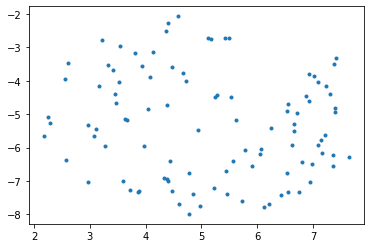

Num_Iter:1e+02 Result:0.1700 Error:34.1% TimeElapsed:0.28 Method:C=>S, Array


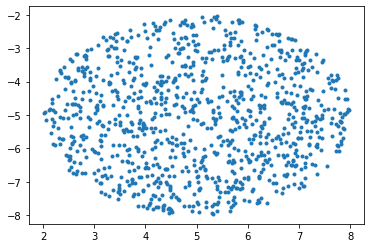

Num_Iter:1e+03 Result:0.1210 Error:-4.5% TimeElapsed:0.31 Method:C=>S, Array


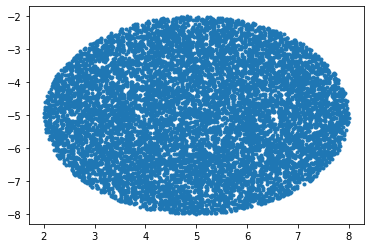

Num_Iter:1e+04 Result:0.1259 Error:-0.7% TimeElapsed:0.25 Method:C=>S, Array


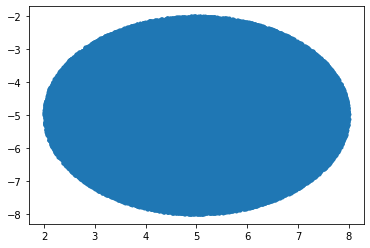

Num_Iter:1e+05 Result:0.1283 Error:1.2% TimeElapsed:0.59 Method:C=>S, Array


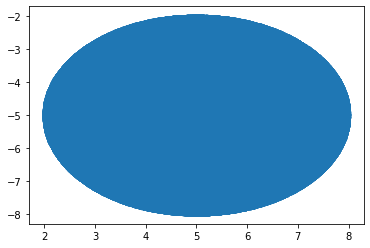

Num_Iter:1e+06 Result:0.1269 Error:0.1% TimeElapsed:3.23 Method:C=>S, Array


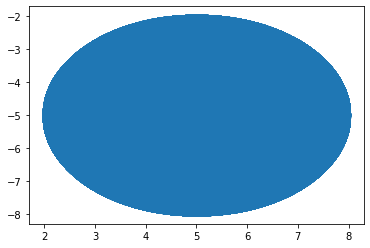

Num_Iter:1e+07 Result:0.1265 Error:-0.2% TimeElapsed:29.98 Method:C=>S, Array


In [5]:
def f_a():
    return 1.0
def f_b(xc,y0,yc,z0,zc,theta,phi):
    return np.sin(theta) *np.cos(phi)*(2*yc-2*y0)+np.sin(theta)*np.sin(phi)*(2*z0-2*zc)-2*xc*np.cos(theta)
def f_c(xc,y0,yc,z0,zc,rs):
    return np.square(xc)+np.square(yc)+np.square(zc)+np.square(y0)+np.square(z0)-2*yc*y0-2*zc*z0-np.square(rs)
#Outputs r and an boolean array which is True where r>0
def f_r_and_valid(a,b,c):
    r = np.zeros_like(b)
    #check if negative under radical
    I = (4*a*c)>(np.square(b))
    r[~I]= ((-1* b[~I] - np.sqrt(np.square(b[~I])-4*a*c[~I]))/(2*a)) 
    return r, r>(1e-10)
def f_y0(y_c,r0,angle0):
    return y_c + r0 * np.sin(angle0)
def f_z0(z_c,r0,angle0):
    return z_c - r0 * np.cos(angle0)
def valid_intersection(xc,yc,zc,y0,z0,rs,theta,phi):
    a = f_a()
    b = f_b(xc,y0,yc,z0,zc,theta,phi)
    c = f_c(xc,y0,yc,z0,zc,rs)
    r,valids = f_r_and_valid(a,b,c)
    return valids
def rand_gen_theta(shape):
    return np.arcsin(np.sqrt(np.random.random(shape)))
def rand_gen_phi(shape):
    return np.random.random(shape) * 2 * np.pi
def rand_gen_r0(shape,r_c):
    return np.sqrt(np.random.random(shape)) * r_c
def rand_gen_angle0(shape):
    return np.random.random(shape) *2 * np.pi
def main_B_21_fast(iterations):
    xc = 5.0
    yc = 5.0
    zc = -5.0
    rs = 2.0
    r_c = 3.0
    y_c = 5.0
    z_c = -5.0
    
    shape = (iterations,)
    r0 = rand_gen_r0(shape,r_c)
    angle0 = rand_gen_angle0(shape)
    y0 = f_y0(y_c,r0,angle0)
    z0 = f_z0(z_c,r0,angle0)
    plt.plot(y0,z0,'.')
    plt.show()
    theta = rand_gen_theta(shape)
    phi = rand_gen_phi(shape)
    
    res= valid_intersection(xc,yc,zc,y0,z0,rs,theta,phi)
    return np.sum(res) / iterations

area_ratio = (3.0**2 *np.pi)/(4*np.pi * (2.0**2))
s_to_c_theory = 0.0713

theory = s_to_c_theory /area_ratio
print('Circle to Sphere, Theoretical:{:.4f}'.format(theory))
print('')
for iterations in [1e2,1e3,1e4,1e5,1e6,1e7]:
    print_result_and_time(iterations,theory,method='b_21_fast')
     

In [2]:
import matplotlib.pyplot as plt
shape = (1000,)
x0 = np.random.random(shape) * (2+2) - 2 + 5
gamma = np.random.random(shape)*2*np.pi
alpha = np.arccos((x0-5.0)/2.0)
y0 = 5 + 2 * np.sin(alpha) * np.cos(gamma)
plt.plot(x0,y0,'.')
plt.show()

<Figure size 640x480 with 1 Axes>

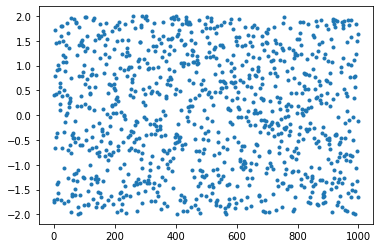

In [32]:
plt.plot(x0,'.')

In [48]:
def a(aa,bb):
    return aa+bb
def print_a(fun,aaa,bbb):
    c =fun(aaa,bbb)
    print(c)
print_a(a,5,10)

15
